In [2]:
import skorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import TensorDataset
from torch.autograd import Variable

In [3]:
from sine_data import train_dataset, valid_dataset

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import insp

In [5]:
import visdom
vis = visdom.Visdom()

In [6]:



X_train, y_train = train_dataset(points=200)
X_train, y_train = torch.Tensor(X_train), torch.LongTensor(y_train)

X_valid, y_valid = valid_dataset(points=400)
X_valid, y_valid = torch.Tensor(X_valid), torch.LongTensor(y_valid)

sine_train_loader = DataLoader(TensorDataset(X_train, y_train),
                               batch_size=64,
                               shuffle=True)
sine_valid_loader = DataLoader(TensorDataset(X_valid, y_valid),
                               batch_size=64,
                               shuffle=False)

In [7]:
class InhCWRNN_sister(nn.Module):
    """simply learning sine parameters from var(sister module)"""
    def __init__(self, input_dim, output_dim, num_modules, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_modules = num_modules
        
        self.input_mod = nn.Linear(input_dim, output_dim)
        self.hidden_mod = nn.Linear(output_dim, output_dim, bias=False)
        
        self.input_period = nn.Linear(input_dim, output_dim)
        self.hidden_period = nn.Linear(output_dim, output_dim, bias=False)
        
        self.module_periods = nn.Parameter(torch.zeros(num_modules) + 1)
        self.module_shifts = nn.Parameter(torch.zeros(num_modules))
        
        self.f_mod = nn.Tanh()        
        
    def step(self, ti, xi, h):
        module_size = self.output_dim // self.num_modules
        
        acts = self.f_mod(self.input_mod(xi) + self.hidden_mod(h))
        module_acts = acts.view(-1, self.num_modules, module_size)
        
        acts_period = self.f_mod(self.input_period(xi) + self.hidden_period(h))
        module_acts_period = acts.view(-1, self.num_modules, module_size)
        
        # use variance as indicator for surprisal and, hence, update rate
        surprisal = module_acts_period.var(-1, keepdim=True)
        module_periods = self.module_periods + surprisal
                
        # y=(sin(x)+1)/2 so we y is in [0;1]
        gate = (torch.sin(ti * module_periods + self.module_shifts) + 1) / 2
        #gate = gate.view(1, -1, 1).expand_as(module_acts).contiguous()
        gate = gate.view(-1, self.output_dim)
                
        y = (1 - gate) * acts + gate * h
        
        return y, y, module_periods
        
    def init_hidden(self):
        return Variable(torch.zeros(self.output_dim))
        
    def forward(self, x):
        t = x.size(1)
        ys = []
        h = self.init_hidden()
        ps = []
        for ti in range(t):
            xi = x[:, ti]
            yi, h, p = self.step(ti, xi, h)     
            ys.append(yi)
            ps.append(p.squeeze(-1))
        return torch.stack(ys, dim=1), h, torch.stack(ps, dim=1)

In [14]:
class InhCWRNN_surprisal(nn.Module):
    def __init__(self, input_dim, output_dim, num_modules, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_modules = num_modules
        
        self.input_mod = nn.Linear(input_dim, output_dim)
        self.hidden_mod = nn.Linear(output_dim, output_dim, bias=False)
        
        self.input_rec = nn.Linear(input_dim, input_dim * num_modules)
        self.hidden_rec = nn.Linear(input_dim * num_modules, input_dim * num_modules, bias=False)
        
        self.module_periods = nn.Parameter(torch.zeros(num_modules) + 1)
        self.module_shifts = nn.Parameter(torch.zeros(num_modules))
        
        self.f_mod = nn.Tanh()
        
    def step(self, ti, xi, h, x_pred):
        module_size = self.output_dim // self.num_modules
        
        acts = self.f_mod(self.input_mod(xi) + self.hidden_mod(h))
        module_acts = acts.view(-1, self.num_modules, module_size)
        
        # predict x_{t+1}, store for next step
        acts_rec = self.f_mod(self.input_rec(xi) + self.hidden_rec(x_pred))
        module_acts_rec = acts_rec.view(-1, self.num_modules, self.input_dim)
        
        # compare last prediction with current x, compute surprisal from that
        module_x_pred = x_pred.view(-1, self.num_modules, self.input_dim)
        surprisal = F.log_softmax(module_x_pred) * xi.unsqueeze(1).expand_as(module_acts_rec)
        # compute the mean surprisal for each module
        mean_surprisal = surprisal.mean(-1)
        # use mean surprisal to drive the periodicity of the module's gate
        # weight down surprisal for specific modules
        module_periods = mean_surprisal * self.module_periods
                
        # y=(sin(x)+1)/2 so we y is in [0;1]
        #gate = (torch.sin(ti * module_periods + self.module_shifts) + 1) / 2
        gate = (1/1 * (torch.sin((ti + self.module_shifts) * module_periods * 1)) +
                1/3 * (torch.sin((ti + self.module_shifts) * module_periods * 3)) +
                1/5 * (torch.sin((ti + self.module_shifts) * module_periods * 5)))
        gate = (gate + 1) / 2
        
        gate = gate.unsqueeze(-1).expand_as(module_acts).contiguous()
        gate = gate.view(-1, self.output_dim)
                
        y = (1 - gate) * acts + gate * h
        
        return y, y, acts_rec, module_periods
        
    def init_hidden(self):
        return Variable(torch.zeros(self.output_dim))
        
    def forward(self, x):
        t = x.size(1)
        ys = []
        h = self.init_hidden()
        x_pred = Variable(torch.zeros(self.input_dim * self.num_modules))
        ps = []
        for ti in range(t):
            xi = x[:, ti]
            yi, h, x_pred, p = self.step(ti, xi, h, x_pred) 
            ys.append(yi)
            ps.append(p.squeeze(-1))
        return torch.stack(ys, dim=1), h, torch.stack(ps, dim=1)

In [15]:
def time_flatten(t):
    return t.view(t.size(0) * t.size(1), -1)

def time_unflatten(t, s):
    return t.view(s[0], s[1], -1)

In [22]:
class ReconModel(nn.Module):
    def __init__(self, num_hidden=64, num_modules=8, implementation='surprisal'):
        super().__init__()
        
        if implementation == 'surprisal':
            self.rnn = InhCWRNN_surprisal(1, num_hidden, num_modules)
        elif implementation == 'sister':
            self.rnn = InhCWRNN_sister(1, num_hidden, num_modules)
        else:
            raise ValueError('unk. impl.')
        self.clf = nn.Linear(num_hidden, 1)
        
    def forward(self, x):
        l0, h0, p0 = self.rnn(x)
        
        vis.heatmap(l0[0].data.numpy(), win="act")
        vis.heatmap(p0[0].data.numpy(), win="periods")
        vis.heatmap(self.rnn.module_shifts.data.numpy().reshape(1, -1), win="shifts")

        l1 = self.clf(time_flatten(l0))
        return time_unflatten(l1, x.size())

In [23]:
class Trainer(skorch.NeuralNet):
    def __init__(self, 
                 criterion=nn.MSELoss,
                 *args, 
                 **kwargs):
        super().__init__(*args, criterion=criterion, **kwargs)

    def get_loss(self, y_pred, y_true, X=None, train=False):
        pred = time_flatten(y_pred)
        true = time_flatten(y_true)
        return super().get_loss(pred, true, X=X, train=train)

### exp inhibition

In [24]:
torch.manual_seed(1337)

def my_train_split(X, y):
    return X, X_valid[:, :-1], y, X_valid[:, 1:]

ef_relu = Trainer(module=ReconModel,
             optimizer=torch.optim.Adam,
             lr=0.005,
             max_epochs=30,
             train_split=my_train_split,
             
             module__num_modules=8,
             module__num_hidden=64,
             module__implementation='surprisal',
            )

In [25]:
%pdb on
ef_relu.fit(X_train[:, :-1], X_train[:, 1:])

Automatic pdb calling has been turned ON
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        1.0338        0.4686  0.9076
      2        0.4494        0.2657  0.9418
      3        0.2523        0.1674  0.8573
      4        0.1715        0.1085  1.0003
      5        0.1256        0.1080  0.9658
      6        0.1233        0.1259  0.9712
      7        0.1359        0.1055  0.9293
      8        0.1150        0.0613  0.8909
      9        0.0717        0.0315  0.9354
     10        0.0424        0.0280  0.9212
     11        0.0384        0.0363  0.9796
     12        0.0431        0.0394  0.9171
     13        0.0443        0.0360  0.9022
     14        0.0385        0.0333  0.8944
     15        0.0348        0.0354  1.0237
     16        0.0368        0.0377  0.9463
     17        0.0394        0.0344  0.9646
     18        0.0365        0.0257  0.9981
     19        0.0284        0.0171  0.9135
     20        0.0205        0.0124

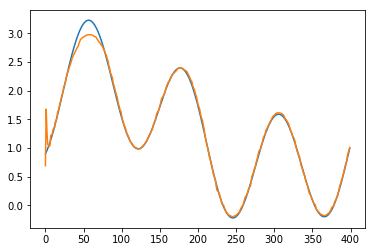

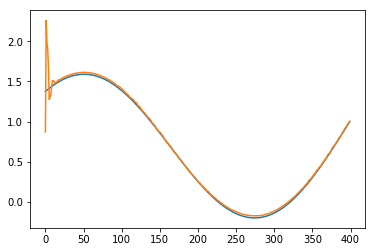

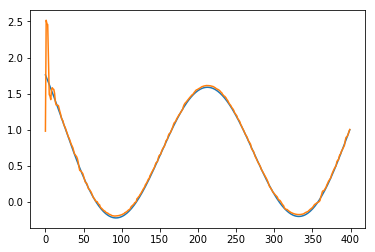

In [26]:
data = X_valid
pred = ef_relu.predict_proba(data)

for i in range(pred.shape[0]):
    plt.figure(i)
    plt.plot(data[i].numpy())
    plt.plot(np.arange(len(pred[i])), pred[i])

In [41]:
%pdb on
ef_relu.fit(X_train[:, :-1], X_train[:, 1:])

Automatic pdb calling has been turned ON
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        1.0320        0.4687  0.6820
      2        0.4482        0.2650  0.6584
      3        0.2502        0.1674  0.6529
      4        0.1704        0.1097  0.6882
      5        0.1226        0.1099  0.6627
      6        0.1239        0.1250  0.6744
      7        0.1360        0.1042  0.6845
      8        0.1144        0.0605  0.6686
      9        0.0712        0.0313  0.6700
     10        0.0418        0.0283  0.6701
     11        0.0368        0.0366  0.6330
     12        0.0423        0.0400  0.6651
     13        0.0432        0.0370  0.6433
     14        0.0387        0.0346  0.6648
     15        0.0359        0.0362  0.6814
     16        0.0376        0.0377  0.6337
     17        0.0392        0.0339  0.6757
     18        0.0357        0.0254  0.6762
     19        0.0276        0.0169  0.6504
     20        0.0199        0.0126

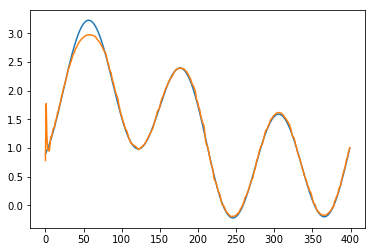

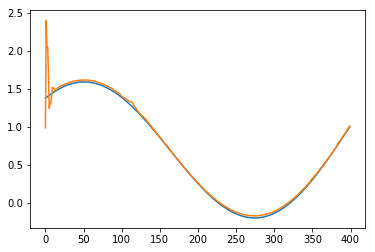

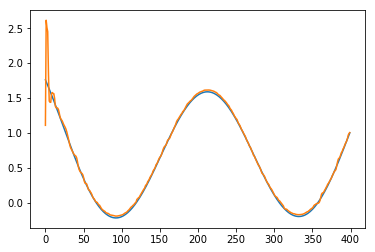

In [42]:
data = X_valid
pred = ef_relu.predict_proba(data)

for i in range(pred.shape[0]):
    plt.figure(i)
    plt.plot(data[i].numpy())
    plt.plot(np.arange(len(pred[i])), pred[i])

In [43]:
torch.manual_seed(1337)

def my_train_split(X, y):
    return X, X_valid[:, :-1], y, X_valid[:, 1:]

ef_relu = Trainer(module=ReconModel,
             optimizer=torch.optim.Adam,
             lr=0.005,
             max_epochs=30,
             train_split=my_train_split,
             
             module__num_modules=8,
             module__num_hidden=64,
             module__implementation='sister',
            )

In [44]:
%pdb on
ef_relu.fit(X_train[:, :-1], X_train[:, 1:])

Automatic pdb calling has been turned ON
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        1.8750        0.9350  0.5038
      2        0.9105        0.4946  0.5573
      3        0.4646        0.2956  0.5538
      4        0.2829        0.1618  0.5278
      5        0.1709        0.0845  0.5861
      6        0.1044        0.1053  0.5532
      7        0.1209        0.1589  0.5496
      8        0.1694        0.1475  0.5826
      9        0.1578        0.0910  0.5799
     10        0.1063        0.0514  0.5145
     11        0.0695        0.0451  0.5834
     12        0.0647        0.0504  0.5761
     13        0.0692        0.0454  0.5133
     14        0.0589        0.0326  0.5665
     15        0.0422        0.0267  0.5567
     16        0.0319        0.0345  0.5328
     17        0.0367        0.0475  0.5669
     18        0.0484        0.0538  0.5582
     19        0.0542        0.0499  0.5313
     20        0.0501        0.0412

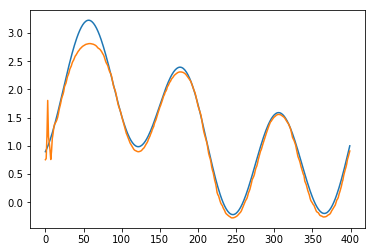

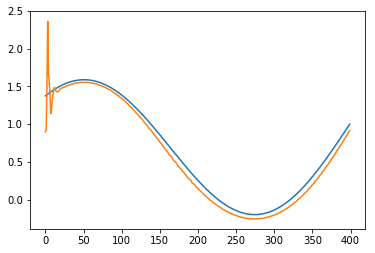

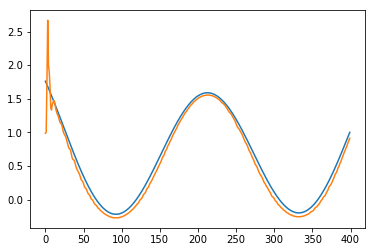

In [45]:
data = X_valid
pred = ef_relu.predict_proba(data)

for i in range(pred.shape[0]):
    plt.figure(i)
    plt.plot(data[i].numpy())
    plt.plot(np.arange(len(pred[i])), pred[i])